<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v3)
This currently just has some small testing against a small improvement to the model code, but I'll probably later re-use it for more interesting things.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  #!cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout e33eb2b
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

Cloning into 'repo'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 395 (delta 56), reused 60 (delta 44), pack-reused 317 (from 1)
Receiving objects: 100% (395/395), 23.56 MiB | 13.34 MiB/s, done.
Resolving deltas: 100% (195/195), done.
Already up to date.


<module 'slam_data' from '/content/repo/slam_data.py'>

In [2]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.6 MB/s eta 0:00:00


In [ ]:
# Load training data
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data1.npz')

Loaded:
  input_maps:        (1000, 149, 149, 3)
  lds_maps:          (1000, 149, 149)
  ground_truth_maps: (1000, 149, 149, 3)
  adlos:             (1000, 4)
Dataset loaded from repo/data/experimental-slam-training-data1.npz


map_shape: (149, 149, 3)
Added final cropping layer: w=11, h=11
Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_167>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_173>]
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 663ms/step - adlo_output_accept_accuracy: 0.6489 - adlo_output_adlo_loss: 1.1523 - adlo_output_loc_error: 0.1526 - adlo_output_orientation_error: 0.0122 - loss: 1.8741 - map_output_accuracy: 0.7157 - map_output_loss: 0.7213
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 398ms/step - adlo_output_accept_accuracy: 0.7440 - adlo_output_adlo_loss: 0.5518 - adlo_output_loc_error: 0.0903 

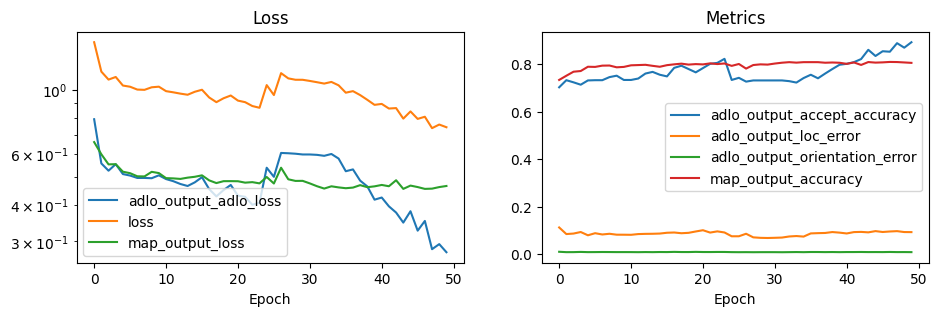

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 8.504174   -0.00997902 -0.01940784 -0.01433059]
adlo-pred scaled: [ 0.9997974  -0.00997902 -0.01940784 -0.01433059]


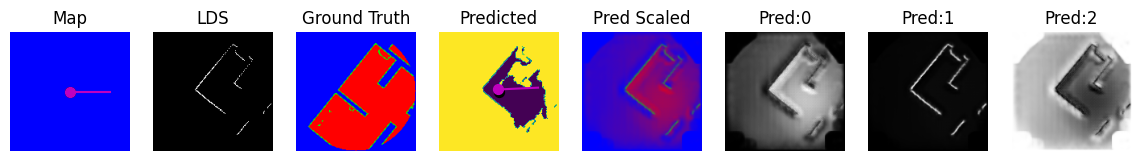

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [ 0.8287652  -0.01557153 -0.01066804  0.04938537]
adlo-pred scaled: [ 0.6960938  -0.01557153 -0.01066804  0.04938537]


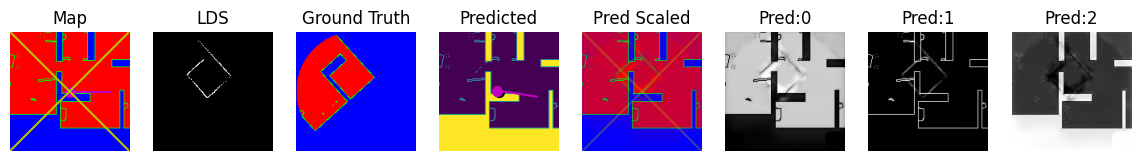

adlo:             [ 1.          0.33607876 -0.16260384  0.29634374]
adlo-pred raw:    [ 1.2234759   0.00219505 -0.01283307  0.03152432]
adlo-pred scaled: [ 0.7726746   0.00219505 -0.01283307  0.03152432]


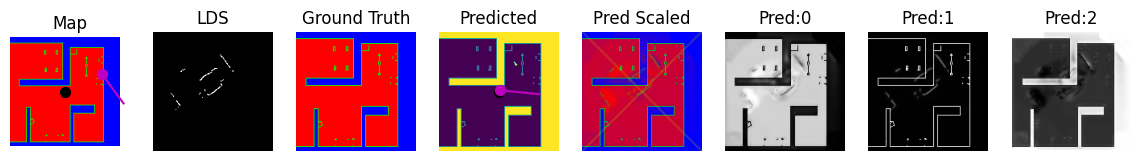

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [13.866342    0.02276803 -0.02712932  0.02343458]
adlo-pred scaled: [ 0.99999905  0.02276803 -0.02712932  0.02343458]


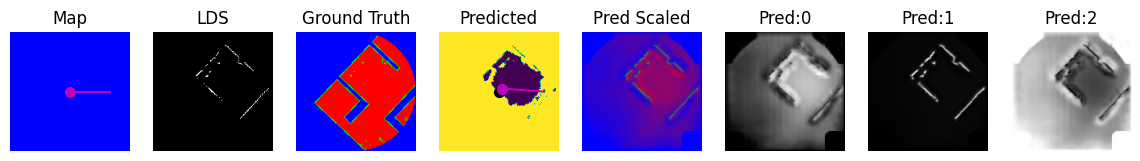

adlo:             [1.         0.17887953 0.22063265 0.16403958]
adlo-pred raw:    [ 2.6810937e+00  1.1810708e-03 -3.8655940e-02  4.5666143e-02]
adlo-pred scaled: [ 0.93590176  0.00118107 -0.03865594  0.04566614]


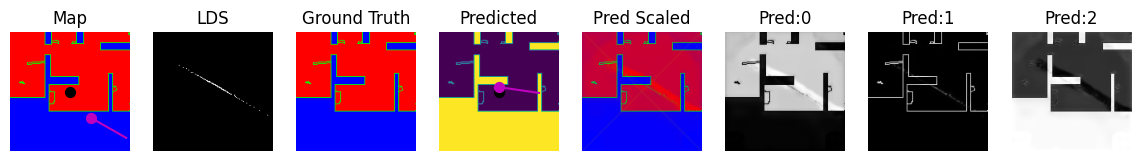

In [ ]:
reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': slam.ADLOLoss()
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='loss'), 'accuracy'],
                  'adlo_output': [slam.ADLOLoss(), slam.AcceptAccuracy(), slam.LocationError(), slam.OrientationError()]
              })

epochs = 50
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')

In [ ]:
# further epochs
epochs = 50
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - adlo_output_accept_accuracy: 0.8994 - adlo_output_adlo_loss: 0.2497 - adlo_output_loc_error: 0.0886 - adlo_output_orientation_error: 0.0081 - loss: 0.7185 - map_output_accuracy: 0.7990 - map_output_loss: 0.4686
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - adlo_output_accept_accuracy: 0.9417 - adlo_output_adlo_loss: 0.1611 - adlo_output_loc_error: 0.0984 - adlo_output_orientation_error: 0.0089 - loss: 0.5997 - map_output_accuracy: 0.8149 - map_output_loss: 0.4389
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 407ms/step - adlo_output_accept_accuracy: 0.9468 - adlo_output_adlo_loss: 0.1462 - adlo_output_loc_error: 0.0920 - adlo_output_orientation_error: 0.0084 - loss: 0.5904 - map_output_accuracy: 0.8105 - map_output_loss: 0.4440
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - adlo_output_accept_accuracy: 0.9476 - adlo_output_adlo_loss: 0.1640 - adlo_output_loc_error: 0.0976 - adlo_output_orientation_error: 0.0081 - loss:

AttributeError: 'dict' object has no attribute 'history'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [12.737548    0.01913706  0.03509619  0.03254162]
adlo-pred scaled: [0.999997   0.01913706 0.03509619 0.03254162]


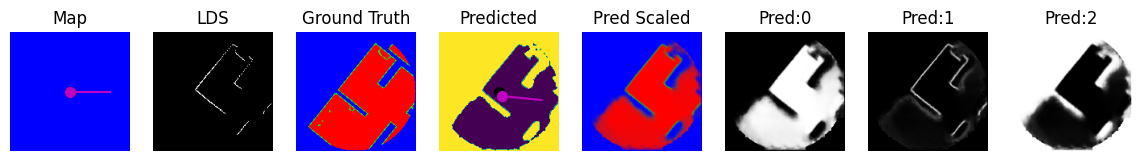

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-1.5973332e+01  1.1810327e-02 -3.4842771e-02  1.0659693e-02]
adlo-pred scaled: [ 1.15576576e-07  1.18103269e-02 -3.48427705e-02  1.06596928e-02]


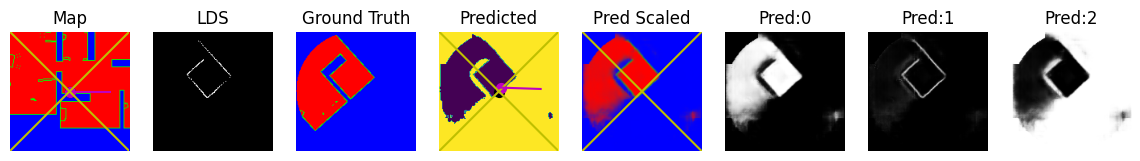

adlo:             [ 1.          0.33607876 -0.16260384  0.29634374]
adlo-pred raw:    [ 7.4478064   0.11250391 -0.11126629  0.16776136]
adlo-pred scaled: [ 0.99941766  0.11250391 -0.11126629  0.16776136]


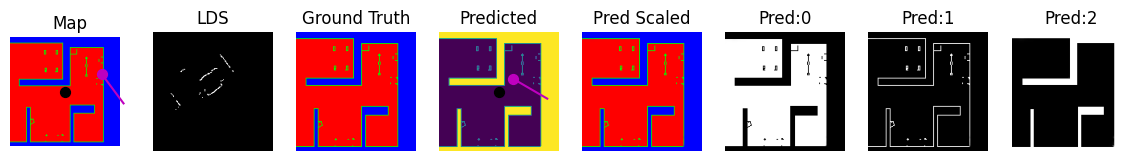

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [11.666432    0.02440189 -0.02359107  0.05653602]
adlo-pred scaled: [ 0.9999914   0.02440189 -0.02359107  0.05653602]


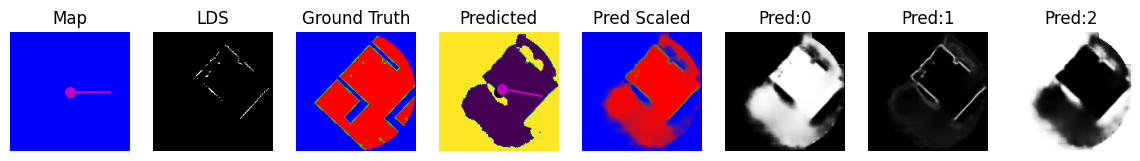

adlo:             [1.         0.17887953 0.22063265 0.16403958]
adlo-pred raw:    [12.623082    0.06470502  0.07253678  0.20018071]
adlo-pred scaled: [0.99999666 0.06470502 0.07253678 0.20018071]


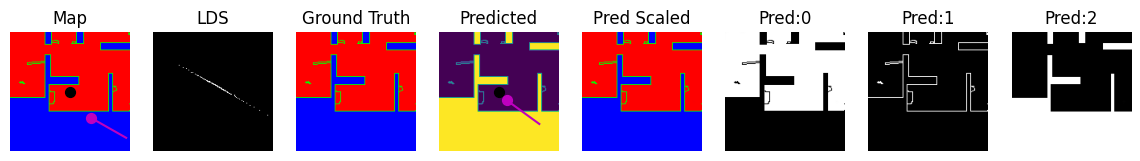

In [ ]:
slam_data.show_predictions(model, train_data, 5, show_classes='pred')

## Checking that we can save and reload
With all the custom functions this might need some extra special work.

In [ ]:
reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

loss = slam.ADLOLoss()
model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              #run_eagerly=True,
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': loss
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='loss'), 'accuracy'],
                  'adlo_output': [slam.ADLOLoss(), slam.AcceptAccuracy(), slam.LocationError(), slam.OrientationError()]
              })
epochs = 1
batch_size = 32
tf.config.run_functions_eagerly(True)
model_train_data = train_data.take(64).shuffle(buffer_size=64).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
model_history = model.fit(model_train_data, epochs=epochs)

map_shape: (149, 149, 3)
Added final cropping layer: w=11, h=11
Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_957>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_963>]
2/2 ━━━━━━━━━━━━━━━━━━━━ 102s 46s/step - adlo_output_accept_accuracy: 0.7812 - adlo_output_adlo_loss: 1.0816 - adlo_output_loc_error: 0.3345 - adlo_output_orientation_error: 0.0210 - loss: 2.1976 - map_output_accuracy: 0.2209 - map_output_loss: 1.1160


In [ ]:
# save model to disk for getting back into this later
model.save('experimental-slam-model3-100epochs.keras')

In [ ]:
# ...or relead
import tensorflow as tf
loaded = tf.keras.models.load_model('model.keras')

In [ ]:
loaded.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lds_input (InputLayer)    │ (None, 149, 149)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ map_input (InputLayer)    │ (None, 149, 149, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 149, 149, 1)    │              0 │ lds_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_14         │ (None, 160, 160, 3)    │              0 │ map_input[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_15         │ (None, 160, 160, 1)    │              0 │ reshape_7[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_203 (Conv2D)       │ (None, 160, 160, 32)   │            896 │ zero_padding2d_14[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_211 (Conv2D)       │ (None, 160, 160, 32)   │            320 │ zero_padding2d_15[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_204 (Conv2D)       │ (None, 160, 160, 32)   │          9,248 │ conv2d_203[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_212 (Conv2D)       │ (None, 160, 160, 32)   │          9,248 │ conv2d_211[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_56          │ (None, 80, 80, 32)     │              0 │ conv2d_204[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_60          │ (None, 80, 80, 32)     │              0 │ conv2d_212[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_205 (Conv2D)       │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_56[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_213 (Conv2D)       │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_206 (Conv2D)       │ (None, 80, 80, 64)     │         36,928 │ conv2d_205[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_214 (Conv2D)       │ (None, 80, 80, 64)     │         36,928 │ conv2d_213[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_57          │ (None, 40, 40, 64)     │              0 │ conv2d_206[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_61          │ (None, 40, 40, 64)     │              0 │ conv2d_214[0][0]       │
│ (MaxPooling2D)       

 Total params: 36,974,759 (141.05 MB)

 Trainable params: 12,324,919 (47.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,649,840 (94.03 MB)

In [ ]:
l = slam.ADLOLoss()
l.get_config()


{'name': 'adlo_loss', 'reduction': 'sum_over_batch_size', '_from_logits': True}

## Train with prediction-generated input maps


Loaded:
  input_maps:        (1000, 159, 159, 3)
  lds_maps:          (1000, 159, 159)
  ground_truth_maps: (1000, 159, 159, 3)
  adlos:             (1000, 4)
Dataset loaded from experimental-slam-training-data2.npz
input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.3613129  -0.14542208 -0.84998183]


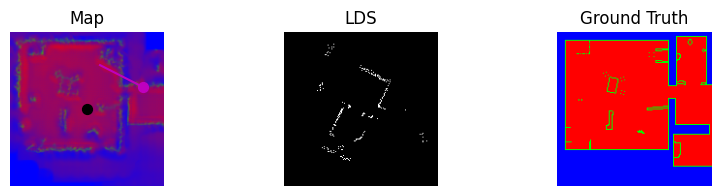

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [1. 0. 0. 0.]


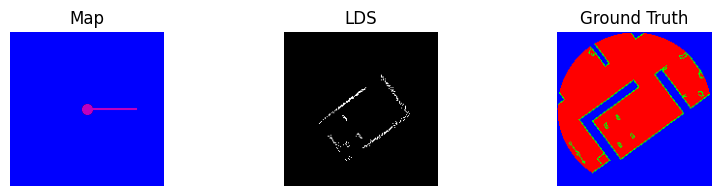

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.4288581  -0.16917454  0.88887873]


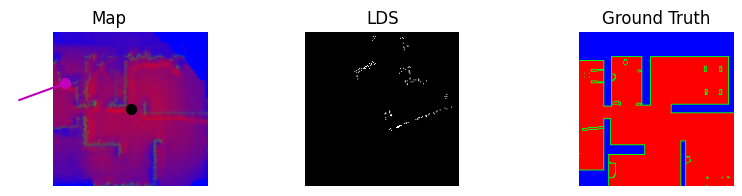

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.08887662 -0.4728966  -0.44646913]


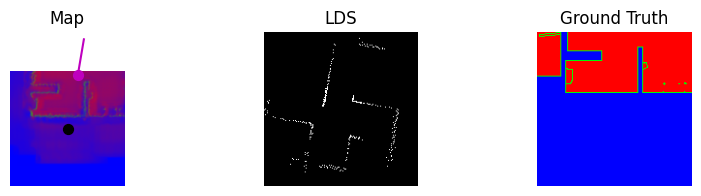

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [0. 0. 0. 0.]


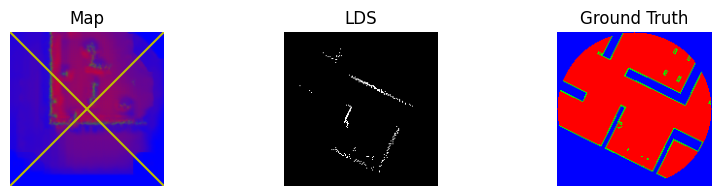

In [8]:
# load training data
train_data = slam_data.load_dataset('experimental-slam-training-data2.npz')
slam_data.show_dataset(train_data)

map_shape: (159, 159, 3)
Added final cropping layer: w=1, h=1
Prepared SLAM model
  Map shape:        (159, 159, 3) + padding (1, 1, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 159, 159), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=False, name=keras_tensor_109>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_115>]
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 698ms/step - adlo_output_accept_accuracy: 0.6945 - adlo_output_adlo_loss: 0.8452 - adlo_output_loc_error: 0.1518 - adlo_output_orientation_error: 0.0130 - loss: 1.7051 - map_output_accuracy: 0.5522 - map_output_loss: 0.8596
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 383ms/step - adlo_output_accept_accuracy: 0.7479 - adlo_output_adlo_loss: 0.5027 - adlo_output_loc_error: 0.0937 - 

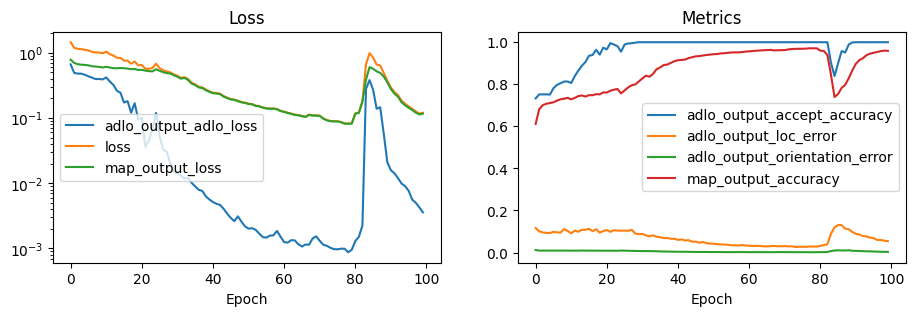

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
adlo:             [ 1.          0.3613129  -0.14542208 -0.84998183]
adlo-pred raw:    [10.507726    0.343536   -0.05889685 -0.85207283]
adlo-pred scaled: [ 0.9999727   0.343536   -0.05889685 -0.85207283]


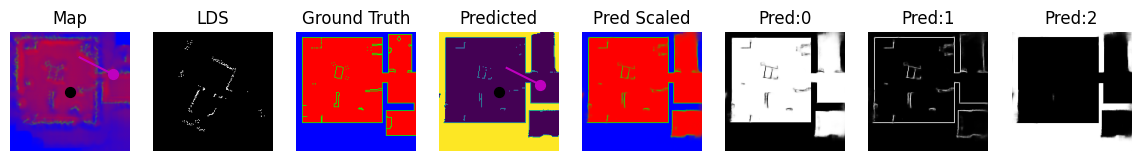

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 9.4432831e+00  5.7364977e-03  1.0094456e-02 -1.2690397e-02]
adlo-pred scaled: [ 0.9999207   0.0057365   0.01009446 -0.0126904 ]


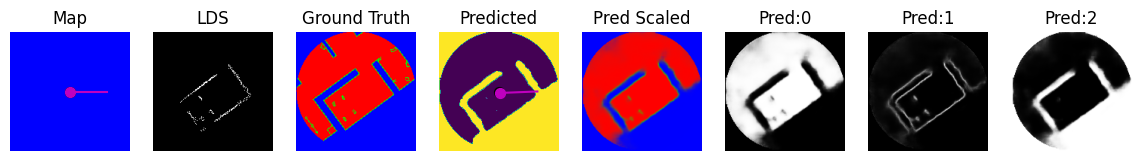

adlo:             [ 1.         -0.4288581  -0.16917454  0.88887873]
adlo-pred raw:    [ 9.469109   -0.15439604  0.01706392  0.759846  ]
adlo-pred scaled: [ 0.99992275 -0.15439604  0.01706392  0.759846  ]


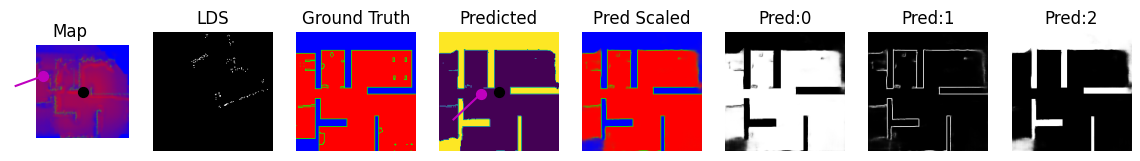

adlo:             [ 1.          0.08887662 -0.4728966  -0.44646913]
adlo-pred raw:    [16.434385    0.07027622 -0.3425067  -0.4342132 ]
adlo-pred scaled: [ 0.9999999   0.07027622 -0.3425067  -0.4342132 ]


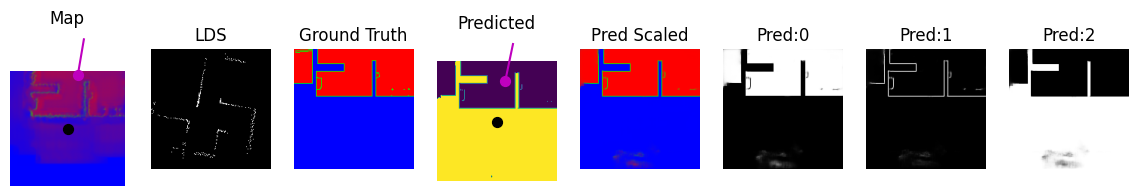

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-9.2079945e+00 -1.4672731e-02 -9.5060095e-05 -1.2263964e-02]
adlo-pred scaled: [ 1.0022482e-04 -1.4672731e-02 -9.5060095e-05 -1.2263964e-02]


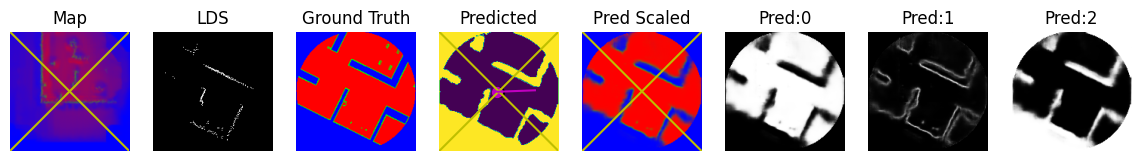

In [10]:
reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': slam.ADLOLoss()
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='loss'), 'accuracy'],
                  'adlo_output': [slam.ADLOLoss(), slam.AcceptAccuracy(), slam.LocationError(), slam.OrientationError()]
              })

epochs = 100
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')